# Directional Coupler Surrogate

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gdstk

# tidy3D imports
import tidy3d as td
from tidy3d import web
import tidy3d.plugins.design as tdd

In [2]:
# wavelength / frequency
lambda0 = 1.550  # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 0.45
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# Reference plane where the cross section of the device is defined
reference_plane = "bottom"
# Angle of the sidewall deviating from the vertical ones, positive values for the base larger than the top
sidewall_angle = np.pi / 6
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# space between waveguide and PML
pml_spacing = 1
# resolution control: minimum number of grid cells per wavelength in each material
grid_cells_per_wvl = 16


In [3]:
def tanh_interp(max_arg):
    """Interpolator for tanh with adjustable extension"""
    scale = 1 / np.tanh(max_arg)
    return lambda u: 0.5 * (1 + scale * np.tanh(max_arg * (u * 2 - 1)))


def make_coupler(
    length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
):
    """Make an integrated coupler using the gdstk RobustPath object."""
    # bend interpolator
    interp = tanh_interp(3)
    delta = wg_width + wg_spacing_coup - wg_spacing_in
    offset = lambda u: wg_spacing_in + interp(u) * delta

    coup = gdstk.RobustPath(
        (-0.5 * length, 0),
        (wg_width, wg_width),
        wg_spacing_in,
        simple_path=True,
        layer=1,
        datatype=[0, 1],
    )
    coup.segment((-0.5 * coup_length - bend_length, 0))
    coup.segment(
        (-0.5 * coup_length, 0),
        offset=[lambda u: -0.5 * offset(u), lambda u: 0.5 * offset(u)],
    )
    coup.segment((0.5 * coup_length, 0))
    coup.segment(
        (0.5 * coup_length + bend_length, 0),
        offset=[lambda u: -0.5 * offset(1 - u), lambda u: 0.5 * offset(1 - u)],
    )
    coup.segment((0.5 * length, 0))
    return coup

In [4]:
def make_sim(coup_length, wg_spacing_coup, domain_field=False):
    """Make a simulation with a given length of the coupling region and
    distance between the waveguides in that region. If ``domain_field``
    is True, a 2D in-plane field monitor will be added.
    """

    # Geometry must be placed in GDS cells to import into Tidy3D
    coup_cell = gdstk.Cell("Coupler")

    substrate = gdstk.rectangle(
        (-device_length / 2, -wg_spacing_in / 2 - 10),
        (device_length / 2, wg_spacing_in / 2 + 10),
        layer=0,
    )
    coup_cell.add(substrate)

    # Add the coupler to a gdstk cell
    gds_coup = make_coupler(
        device_length,
        wg_spacing_in,
        wg_width,
        wg_spacing_coup,
        coup_length,
        bend_length,
    )
    coup_cell.add(gds_coup)

    # Substrate
    (oxide_geo,) = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=0,
        gds_dtype=0,
        slab_bounds=(-10, 0),
        reference_plane=reference_plane,
        axis=2,
    )

    oxide = td.Structure(geometry=oxide_geo, medium=mat_sub)

    # Waveguides (import all datatypes if gds_dtype not specified)
    coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=1,
        slab_bounds=(0, wg_height),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
        axis=2,
    )

    coupler1 = td.Structure(geometry=coupler1_geo, medium=mat_wg)

    coupler2 = td.Structure(geometry=coupler2_geo, medium=mat_wg)

    # Simulation size along propagation direction
    sim_length = 2 + 2 * bend_length + coup_length

    # Spacing between waveguides and PML
    sim_size = [
        sim_length,
        wg_spacing_in + wg_width + 2 * pml_spacing,
        wg_height + 2 * pml_spacing,
    ]

    # source
    src_pos = -sim_length / 2 + 0.5
    msource = td.ModeSource(
        center=[src_pos, wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=td.ModeSpec(),
        mode_index=0,
    )

    mon_in = td.ModeMonitor(
        center=[(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=freqs,
        mode_spec=td.ModeSpec(),
        name="in",
    )
    mon_ref_bot = td.ModeMonitor(
        center=[(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=freqs,
        mode_spec=td.ModeSpec(),
        name="reflect_bottom",
    )
    mon_top = td.ModeMonitor(
        center=[-(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=freqs,
        mode_spec=td.ModeSpec(),
        name="top",
    )
    mon_bot = td.ModeMonitor(
        center=[-(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=freqs,
        mode_spec=td.ModeSpec(),
        name="bottom",
    )
    monitors = [mon_in, mon_ref_bot, mon_top, mon_bot]

    if domain_field == True:
        domain_monitor = td.FieldMonitor(
            center=[0, 0, wg_height / 2],
            size=[td.inf, td.inf, 0],
            freqs=freqs,
            name="field",
        )
        monitors.append(domain_monitor)

    # initialize the simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=grid_cells_per_wvl),
        structures=[oxide, coupler1, coupler2],
        sources=[msource],
        monitors=monitors,
        run_time=50 / fwidth,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    )

    return sim

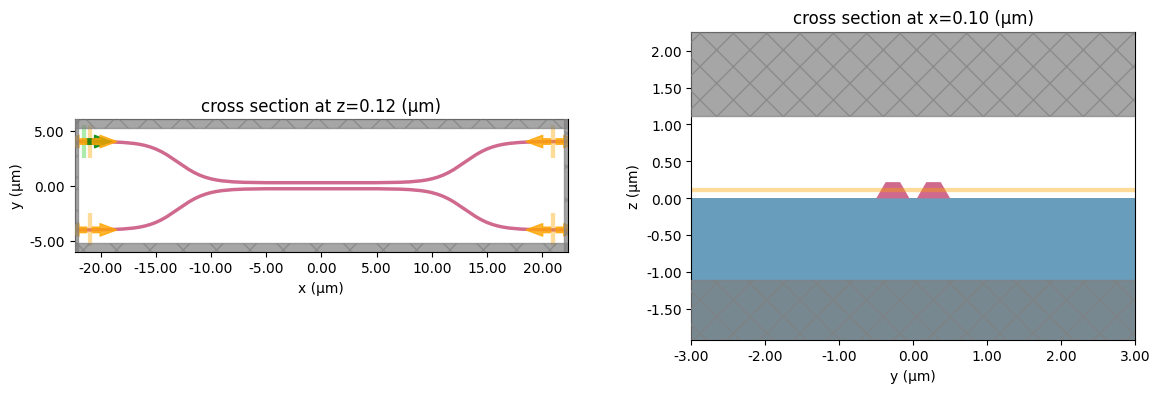

In [5]:
# Length of the coupling region
coup_length = 10

# Waveguide separation in the coupling region
wg_spacing_coup = 0.10

sim = make_sim(coup_length, wg_spacing_coup, domain_field=True)

# visualize geometry
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sim.plot(z=wg_height / 2 + 0.01, ax=ax1)
sim.plot(x=0.1, ax=ax2)
ax2.set_xlim([-3, 3])
plt.show()

In [5]:
def measure_transmission(sim_data):
    """Constructs a "row" of the scattering matrix when sourced from top left port"""

    input_amp = sim_data["in"].amps.sel(direction="+")

    amps_dict = {}
    directions = ("-", "-", "+", "+")
    for i, (monitor, direction) in enumerate(
        zip(sim_data.simulation.monitors[:4], directions)
    ):
        amp = sim_data[monitor.name].amps.sel(direction=direction)
        amp_normalized = amp / input_amp
        amps_dict[monitor.name] = amp_normalized 

    return amps_dict

def fn_post(*args, **kwargs):
    """Post processing function, but label the outputs using a dictionary."""
    amps_dict = measure_transmission(*args, **kwargs)
    return amps_dict

In [6]:
param_spc = tdd.ParameterFloat(name="wg_spacing_coup", span=(0.05, 0.25))
param_len = tdd.ParameterFloat(name="coup_length", span=(2, 16))
parameters = [param_spc, param_len]

monte_carlo=tdd.MethodMonteCarlo(
    num_points=100,
    seed=2,
)

design_space = tdd.DesignSpace(method=monte_carlo, parameters=parameters, task_name="DC_MC_Surrogate", path_dir="/home/matt/Documents/Flexcompute/dc/data")

In [7]:
# Run the MC
results = design_space.run(make_sim, fn_post, verbose=True)
df = results.to_dataframe()

15:39:59 BST Running 100 Simulations

In [8]:
# TESTING: Save off the df or load the df
import pickle
import os
os.chdir("/home/matt/Documents/Flexcompute/dc/data")
# with open("result_100.pkl", "wb") as out_file:
#     pickle.dump(results, out_file)


with open("result_100.pkl", "rb") as in_file:
    results = pickle.load(in_file)

df = results.to_dataframe()

<Axes: xlabel='coup_length', ylabel='wg_spacing_coup'>

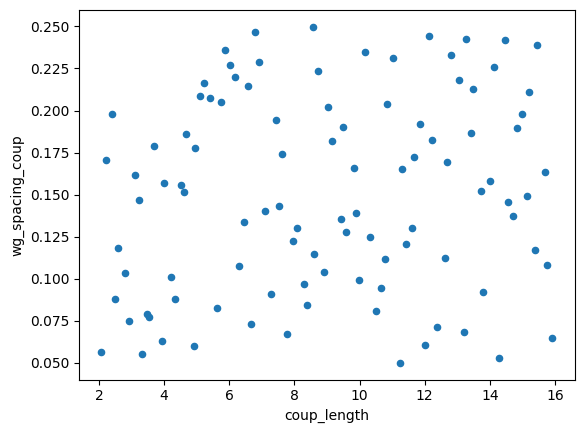

In [22]:
import matplotlib.colors as mcolors
df.plot.scatter("coup_length", "wg_spacing_coup")

# top_cent = df["top"].apply(lambda x: x.sel(f=freq0, method="nearest"))
# bot_cent = df["bottom"].apply(lambda x: x.sel(f=freq0, method="nearest"))

# fitness_val = -(abs(top_cent - 0.25)**2 + abs(bot_cent - 0.75)**2)
# list_fit = [float(val.data) for val in fitness_val]

# norm = mcolors.Normalize(vmin=0, vmax=-1)

# scatter = plt.scatter(df["coup_length"], df["wg_spacing_coup"], c=list_fit, norm=norm)
# plt.xlabel("coup_length")
# plt.ylabel("wg_spacing_coup")
# plt.colorbar(scatter)
# plt.show()

## Surrogate

In [9]:
expanded_df = df.copy()
expanded_df.drop("in", axis=1, inplace=True)
expanded_df.drop("reflect_bottom", axis=1, inplace=True)
expanded_df = expanded_df.explode(["top", "bottom"]).reset_index(drop=True)
expanded_df["freq"] = expanded_df["top"].apply(lambda x: float(x.f))

expanded_df["top"] = expanded_df["top"].apply(lambda x: float(abs(x)**2))
expanded_df["bottom"] = expanded_df["bottom"].apply(lambda x: float(abs(x)**2))


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

from tidy3d.plugins.design.surrogate_object import AI_Model

# Constants
output_dir = "/home/matt/Documents/Flexcompute/dc"
data_dir = ["/home/matt/Documents/Flexcompute/dc/data/"]

test_percentage = 0.20
valid_percentage = 0.20
batch_size = 64
epochs = 200

trial_count = 50

model = AI_Model(output_dir, data_dir, seed=1)

model.load_data_from_df(
    df=expanded_df,
    label_names=["top", "bottom"],
    feature_names=["wg_spacing_coup", "coup_length", "freq"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True
)

loss_fn = nn.MSELoss()

Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


In [23]:
# Define the model in PyTorch
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 2))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

Using existing directory at Model1


  2%|▏         | 2/100 [00:00<00:08, 11.68it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2


  4%|▍         | 4/100 [00:00<00:08, 10.99it/s]

Best State Updated. Epoch: 3
Best State Updated. Epoch: 4


  6%|▌         | 6/100 [00:00<00:08, 11.71it/s]

Best State Updated. Epoch: 5


  8%|▊         | 8/100 [00:00<00:07, 12.03it/s]

Best State Updated. Epoch: 6
Best State Updated. Epoch: 7
Best State Updated. Epoch: 8


 10%|█         | 10/100 [00:00<00:07, 11.44it/s]

Best State Updated. Epoch: 9
Best State Updated. Epoch: 10


 12%|█▏        | 12/100 [00:01<00:07, 11.77it/s]

Best State Updated. Epoch: 11
Best State Updated. Epoch: 12


 14%|█▍        | 14/100 [00:01<00:08, 10.70it/s]

Best State Updated. Epoch: 13
Best State Updated. Epoch: 14


 16%|█▌        | 16/100 [00:01<00:07, 11.27it/s]

Best State Updated. Epoch: 15


 18%|█▊        | 18/100 [00:01<00:07, 11.26it/s]

Best State Updated. Epoch: 16
Best State Updated. Epoch: 17
Best State Updated. Epoch: 18


 20%|██        | 20/100 [00:01<00:07, 11.15it/s]

Best State Updated. Epoch: 19
Best State Updated. Epoch: 20


 22%|██▏       | 22/100 [00:01<00:07, 11.05it/s]

Best State Updated. Epoch: 21


 24%|██▍       | 24/100 [00:02<00:06, 11.14it/s]

Best State Updated. Epoch: 22
Best State Updated. Epoch: 23
Best State Updated. Epoch: 24


 26%|██▌       | 26/100 [00:02<00:06, 11.60it/s]

Best State Updated. Epoch: 25
Best State Updated. Epoch: 26


 28%|██▊       | 28/100 [00:02<00:06, 11.85it/s]

Best State Updated. Epoch: 27
Best State Updated. Epoch: 28


 30%|███       | 30/100 [00:02<00:06, 10.78it/s]

Best State Updated. Epoch: 29
Best State Updated. Epoch: 30


 32%|███▏      | 32/100 [00:02<00:06, 11.25it/s]

Best State Updated. Epoch: 31


 34%|███▍      | 34/100 [00:02<00:05, 11.64it/s]

Best State Updated. Epoch: 32
Best State Updated. Epoch: 33
Best State Updated. Epoch: 34


 40%|████      | 40/100 [00:03<00:05, 11.89it/s]

Best State Updated. Epoch: 37
Best State Updated. Epoch: 38


 42%|████▏     | 42/100 [00:03<00:04, 11.69it/s]

Best State Updated. Epoch: 40
Best State Updated. Epoch: 42


 48%|████▊     | 48/100 [00:04<00:04, 12.21it/s]

Best State Updated. Epoch: 45


 50%|█████     | 50/100 [00:04<00:04, 11.44it/s]

Best State Updated. Epoch: 48
Best State Updated. Epoch: 50


 54%|█████▍    | 54/100 [00:04<00:03, 12.09it/s]

Best State Updated. Epoch: 51


 58%|█████▊    | 58/100 [00:05<00:03, 12.17it/s]

Best State Updated. Epoch: 55


 62%|██████▏   | 62/100 [00:05<00:03, 12.55it/s]

Best State Updated. Epoch: 59
Best State Updated. Epoch: 61


 66%|██████▌   | 66/100 [00:05<00:02, 11.82it/s]

Best State Updated. Epoch: 63


 70%|███████   | 70/100 [00:05<00:02, 12.10it/s]

Best State Updated. Epoch: 67
Best State Updated. Epoch: 69


 90%|█████████ | 90/100 [00:07<00:00, 12.78it/s]

Best State Updated. Epoch: 88


 96%|█████████▌| 96/100 [00:08<00:00, 12.54it/s]

Best State Updated. Epoch: 94


100%|██████████| 100/100 [00:08<00:00, 12.33it/s]

Best State Updated. Epoch: 97


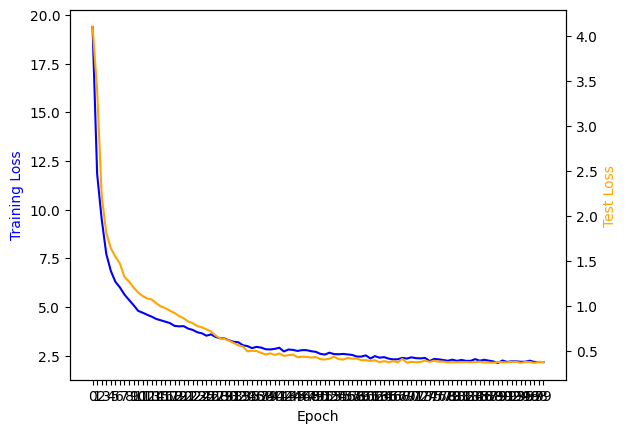

100%|██████████| 100/100 [00:08<00:00, 11.80it/s]

 Best Test Loss: 0.3617747128009796
RMSE: 0.105652
MAE: 0.067852


In [30]:
# Create single model
network = VariableANN(3, [16, 16, 16], 0.2)
opt = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.0001)

trained_net = model.train_model("Model1", network, opt, loss_fn, epochs, plot_output=True)
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

[I 2024-08-22 16:22:04,151] A new study created in memory with name: no-name-f006a447-2db8-4640-a786-cac7c6932f59


Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.19it/s]
[I 2024-08-22 16:22:22,042] Trial 0 finished with value: 0.112794 and parameters: {'dropout': 0.2, 'neurons0': 192, 'neurons1': 16, 'neurons2': 80, 'neurons3': 48, 'lr': 2.3407464805767515e-05, 'weight_decay': 2.3578730726467393e-05}. Best is trial 0 with value: 0.112794.


 Best Test Loss: 0.41268548369407654
RMSE: 0.112794
MAE: 0.074627
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.22it/s]
[I 2024-08-22 16:22:39,886] Trial 1 finished with value: 0.042642 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 112, 'neurons1': 144, 'neurons2': 112, 'neurons3': 176, 'lr': 6.573686655138327e-05, 'weight_decay': 0.0005704727088203682}. Best is trial 1 with value: 0.042642.


 Best Test Loss: 0.05898109823465347
RMSE: 0.042642
MAE: 0.025337
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 11.91it/s]
[I 2024-08-22 16:22:56,694] Trial 2 finished with value: 0.026411 and parameters: {'dropout': 0.0, 'neurons0': 176, 'neurons1': 112, 'neurons2': 144, 'neurons3': 48, 'lr': 6.200203677164716e-05, 'weight_decay': 0.00039947456945609163}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 0.022605016827583313
RMSE: 0.026411
MAE: 0.012297
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.30it/s]
[I 2024-08-22 16:23:14,411] Trial 3 finished with value: 0.161378 and parameters: {'dropout': 0.5, 'neurons0': 96, 'neurons1': 192, 'neurons2': 240, 'neurons3': 240, 'lr': 2.1886526657465428e-05, 'weight_decay': 1.197042490409919e-05}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 0.8475991487503052
RMSE: 0.161378
MAE: 0.131121
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 11.80it/s]
[I 2024-08-22 16:23:31,370] Trial 4 finished with value: 0.032214 and parameters: {'dropout': 0.05, 'neurons0': 240, 'neurons1': 32, 'neurons2': 112, 'neurons3': 256, 'lr': 0.0013572540301313666, 'weight_decay': 0.00024196593469527324}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 0.03369837999343872
RMSE: 0.032214
MAE: 0.020061
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 11.85it/s]
[I 2024-08-22 16:23:48,258] Trial 5 finished with value: 0.339617 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 176, 'neurons1': 224, 'neurons2': 16, 'neurons3': 208, 'lr': 0.0902494067192741, 'weight_decay': 0.0003135676915341995}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 3.772806406021118
RMSE: 0.339617
MAE: 0.302678
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 11.82it/s]
[I 2024-08-22 16:24:05,195] Trial 6 finished with value: 0.0444 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 208, 'neurons1': 32, 'neurons2': 128, 'neurons3': 240, 'lr': 0.0001494364677378836, 'weight_decay': 3.763142612534587e-05}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 0.06404069811105728
RMSE: 0.0444
MAE: 0.034246
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.67it/s]
[I 2024-08-22 16:24:22,349] Trial 7 finished with value: 0.038942 and parameters: {'dropout': 0.05, 'neurons0': 16, 'neurons1': 176, 'neurons2': 64, 'neurons3': 80, 'lr': 0.0009253214657642581, 'weight_decay': 1.2785717080546074e-05}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 0.04928644746541977
RMSE: 0.038942
MAE: 0.027891
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.74it/s]
[I 2024-08-22 16:24:39,399] Trial 8 finished with value: 0.070855 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 48, 'neurons1': 160, 'neurons2': 192, 'neurons3': 32, 'lr': 0.00045313118440918, 'weight_decay': 0.0002447937444286876}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 0.16307993233203888
RMSE: 0.070855
MAE: 0.051901
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.68it/s]
[I 2024-08-22 16:24:56,529] Trial 9 finished with value: 0.177512 and parameters: {'dropout': 0.2, 'neurons0': 16, 'neurons1': 144, 'neurons2': 176, 'neurons3': 144, 'lr': 0.06003147633638411, 'weight_decay': 0.00014897386352200276}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 1.0276376008987427
RMSE: 0.177512
MAE: 0.1506
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.51it/s]
[I 2024-08-22 16:25:13,930] Trial 10 finished with value: 0.060673 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 144, 'neurons1': 80, 'neurons2': 256, 'neurons3': 96, 'lr': 0.004852851779481773, 'weight_decay': 6.166353164027709e-05}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 0.12000714242458344
RMSE: 0.060673
MAE: 0.045499
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:15<00:00, 12.55it/s]
[I 2024-08-22 16:25:29,888] Trial 11 finished with value: 0.037099 and parameters: {'dropout': 0.0, 'neurons0': 240, 'neurons1': 80, 'neurons2': 176, 'neurons3': 128, 'lr': 0.004893529423944132, 'weight_decay': 0.0009570434832691174}. Best is trial 2 with value: 0.026411.


 Best Test Loss: 0.04480568692088127
RMSE: 0.037099
MAE: 0.021487
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:15<00:00, 12.67it/s]
[I 2024-08-22 16:25:45,696] Trial 12 finished with value: 0.021995 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 80, 'neurons2': 80, 'neurons3': 16, 'lr': 0.004650061166464784, 'weight_decay': 0.00012356611113195884}. Best is trial 12 with value: 0.021995.


 Best Test Loss: 0.015630818903446198
RMSE: 0.021995
MAE: 0.012549
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:15<00:00, 12.72it/s]
[I 2024-08-22 16:26:01,441] Trial 13 finished with value: 0.018268 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 80, 'neurons2': 48, 'neurons3': 16, 'lr': 0.012280238476692185, 'weight_decay': 0.00010759103285445899}. Best is trial 13 with value: 0.018268.


 Best Test Loss: 0.010832251980900764
RMSE: 0.018268
MAE: 0.011921
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.40it/s]
[I 2024-08-22 16:26:19,015] Trial 14 finished with value: 0.042624 and parameters: {'dropout': 0.05, 'neurons0': 256, 'neurons1': 80, 'neurons2': 16, 'neurons3': 16, 'lr': 0.014881540808855733, 'weight_decay': 8.84006325926765e-05}. Best is trial 13 with value: 0.018268.


 Best Test Loss: 0.05921504274010658
RMSE: 0.042624
MAE: 0.030884
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]
[I 2024-08-22 16:26:36,565] Trial 15 finished with value: 0.114142 and parameters: {'dropout': 0.4, 'neurons0': 224, 'neurons1': 112, 'neurons2': 64, 'neurons3': 96, 'lr': 0.01616668926771015, 'weight_decay': 0.00011664405434593318}. Best is trial 13 with value: 0.018268.


 Best Test Loss: 0.4222683310508728
RMSE: 0.114142
MAE: 0.078039
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.65it/s]
[I 2024-08-22 16:26:53,759] Trial 16 finished with value: 0.034428 and parameters: {'dropout': 0.1, 'neurons0': 256, 'neurons1': 64, 'neurons2': 48, 'neurons3': 16, 'lr': 0.005572557910946743, 'weight_decay': 5.4289096364412335e-05}. Best is trial 13 with value: 0.018268.


 Best Test Loss: 0.038518160581588745
RMSE: 0.034428
MAE: 0.025656
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 12.41it/s]
[I 2024-08-22 16:27:09,892] Trial 17 finished with value: 0.018532 and parameters: {'dropout': 0.0, 'neurons0': 208, 'neurons1': 112, 'neurons2': 96, 'neurons3': 64, 'lr': 0.028840342784745027, 'weight_decay': 0.0001681968338922541}. Best is trial 13 with value: 0.018268.


 Best Test Loss: 0.011210169643163681
RMSE: 0.018532
MAE: 0.014333
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 11.89it/s]
[I 2024-08-22 16:27:26,732] Trial 18 finished with value: 0.107848 and parameters: {'dropout': 0.25, 'neurons0': 144, 'neurons1': 112, 'neurons2': 32, 'neurons3': 64, 'lr': 0.023729935973361083, 'weight_decay': 0.00016054322828967275}. Best is trial 13 with value: 0.018268.


 Best Test Loss: 0.37802645564079285
RMSE: 0.107848
MAE: 0.080803
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 11.77it/s]
[I 2024-08-22 16:27:43,753] Trial 19 finished with value: 0.065828 and parameters: {'dropout': 0.1, 'neurons0': 208, 'neurons1': 224, 'neurons2': 96, 'neurons3': 128, 'lr': 0.03638194034866235, 'weight_decay': 2.8001139863065e-05}. Best is trial 13 with value: 0.018268.


 Best Test Loss: 0.14065654575824738
RMSE: 0.065828
MAE: 0.046513
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.73it/s]
[I 2024-08-22 16:28:00,829] Trial 20 finished with value: 0.065168 and parameters: {'dropout': 0.45, 'neurons0': 176, 'neurons1': 48, 'neurons2': 144, 'neurons3': 80, 'lr': 0.0016347225936026199, 'weight_decay': 6.970291572735278e-05}. Best is trial 13 with value: 0.018268.


 Best Test Loss: 0.1382252722978592
RMSE: 0.065168
MAE: 0.050271
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:15<00:00, 12.62it/s]
[I 2024-08-22 16:28:16,695] Trial 21 finished with value: 0.024711 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 112, 'neurons2': 64, 'neurons3': 16, 'lr': 0.009642112866237527, 'weight_decay': 0.00017405751147129493}. Best is trial 13 with value: 0.018268.


 Best Test Loss: 0.019761448726058006
RMSE: 0.024711
MAE: 0.013147
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 12.30it/s]
[I 2024-08-22 16:28:32,982] Trial 22 finished with value: 0.015727 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 96, 'neurons2': 96, 'neurons3': 48, 'lr': 0.0027841070118371893, 'weight_decay': 0.00010130592413249617}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.008028081618249416
RMSE: 0.015727
MAE: 0.009487
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 11.77it/s]
[I 2024-08-22 16:28:50,003] Trial 23 finished with value: 0.024898 and parameters: {'dropout': 0.1, 'neurons0': 224, 'neurons1': 128, 'neurons2': 96, 'neurons3': 48, 'lr': 0.0022807956583478692, 'weight_decay': 9.872154801905294e-05}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.020162036642432213
RMSE: 0.024898
MAE: 0.019032
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.69it/s]
[I 2024-08-22 16:29:07,135] Trial 24 finished with value: 0.047508 and parameters: {'dropout': 0.05, 'neurons0': 208, 'neurons1': 96, 'neurons2': 48, 'neurons3': 64, 'lr': 0.02825390137212004, 'weight_decay': 3.774872637805281e-05}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.07350809127092361
RMSE: 0.047508
MAE: 0.035779
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 12.34it/s]
[I 2024-08-22 16:29:23,363] Trial 25 finished with value: 0.017413 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 256, 'neurons2': 128, 'neurons3': 112, 'lr': 0.0004902490404983669, 'weight_decay': 0.00022283234465029483}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.009870803914964199
RMSE: 0.017413
MAE: 0.008964
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 11.76it/s]
[I 2024-08-22 16:29:40,386] Trial 26 finished with value: 0.030075 and parameters: {'dropout': 0.1, 'neurons0': 160, 'neurons1': 256, 'neurons2': 160, 'neurons3': 160, 'lr': 0.00048426306666429005, 'weight_decay': 0.0005271475514398779}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.029337242245674133
RMSE: 0.030075
MAE: 0.018192
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.61it/s]
[I 2024-08-22 16:29:57,639] Trial 27 finished with value: 0.019353 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 256, 'neurons2': 128, 'neurons3': 112, 'lr': 0.0003101229466580497, 'weight_decay': 0.00023825890440180432}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.012102421373128891
RMSE: 0.019353
MAE: 0.011496
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 11.84it/s]
[I 2024-08-22 16:30:14,555] Trial 28 finished with value: 0.028709 and parameters: {'dropout': 0.2, 'neurons0': 112, 'neurons1': 208, 'neurons2': 208, 'neurons3': 32, 'lr': 0.0023078942330100774, 'weight_decay': 6.517530982177254e-05}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.026840485632419586
RMSE: 0.028709
MAE: 0.020743
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.75it/s]
[I 2024-08-22 16:30:31,592] Trial 29 finished with value: 0.035747 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 192, 'neurons1': 48, 'neurons2': 80, 'neurons3': 48, 'lr': 0.0007324530323701436, 'weight_decay': 4.4001463096989834e-05}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.04144815355539322
RMSE: 0.035747
MAE: 0.026408
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.26it/s]
[I 2024-08-22 16:30:49,380] Trial 30 finished with value: 0.117788 and parameters: {'dropout': 0.2, 'neurons0': 240, 'neurons1': 16, 'neurons2': 112, 'neurons3': 176, 'lr': 1.1231851266539406e-05, 'weight_decay': 1.799936084579879e-05}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.4499053955078125
RMSE: 0.117788
MAE: 0.076871
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 12.25it/s]
[I 2024-08-22 16:31:05,736] Trial 31 finished with value: 0.025114 and parameters: {'dropout': 0.0, 'neurons0': 192, 'neurons1': 128, 'neurons2': 96, 'neurons3': 64, 'lr': 0.00989853534493355, 'weight_decay': 0.00019656449591910546}. Best is trial 22 with value: 0.015727.


 Best Test Loss: 0.020420100539922714
RMSE: 0.025114
MAE: 0.01205
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:16<00:00, 12.15it/s]
[I 2024-08-22 16:31:22,216] Trial 32 finished with value: 0.013615 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 96, 'neurons2': 112, 'neurons3': 96, 'lr': 0.0001403087381525657, 'weight_decay': 9.190621243189617e-05}. Best is trial 32 with value: 0.013615.


 Best Test Loss: 0.0060198744758963585
RMSE: 0.013615
MAE: 0.008183
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.53it/s]
[I 2024-08-22 16:31:39,588] Trial 33 finished with value: 0.013908 and parameters: {'dropout': 0.05, 'neurons0': 240, 'neurons1': 96, 'neurons2': 128, 'neurons3': 112, 'lr': 0.00013399613455083743, 'weight_decay': 8.295919159098519e-05}. Best is trial 32 with value: 0.013615.


 Best Test Loss: 0.006290038116276264
RMSE: 0.013908
MAE: 0.008969
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.52it/s]
[I 2024-08-22 16:31:56,973] Trial 34 finished with value: 0.017908 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 96, 'neurons2': 144, 'neurons3': 112, 'lr': 0.00010006170715652937, 'weight_decay': 7.907702906792147e-05}. Best is trial 32 with value: 0.013615.


 Best Test Loss: 0.010394411161541939
RMSE: 0.017908
MAE: 0.010756
Making temp model folder
Using existing directory at temp


100%|██████████| 200/200 [00:17<00:00, 11.51it/s]
[I 2024-08-22 16:32:14,385] Trial 35 finished with value: 0.024996 and parameters: {'dropout': 0.1, 'neurons0': 192, 'neurons1': 144, 'neurons2': 128, 'neurons3': 96, 'lr': 0.00021578482366341087, 'weight_decay': 0.000310728220316391}. Best is trial 32 with value: 0.013615.


 Best Test Loss: 0.020234668627381325
RMSE: 0.024996
MAE: 0.014686
Study statistics: 
  Number of finished trials:  36
  Number of pruned trials:  0
  Number of complete trials:  36
Best trial:
  Value:  0.013615
  Params: 
    dropout: 0.0
    neurons0: 224
    neurons1: 96
    neurons2: 112
    neurons3: 96
    lr: 0.0001403087381525657
    weight_decay: 9.190621243189617e-05
Using existing directory at Model1


  0%|          | 1/1000 [00:00<01:55,  8.67it/s]

Best State Updated. Epoch: 0


  0%|          | 3/1000 [00:00<01:31, 10.91it/s]

Best State Updated. Epoch: 1
Best State Updated. Epoch: 2
Best State Updated. Epoch: 3


  0%|          | 5/1000 [00:00<01:45,  9.43it/s]

Best State Updated. Epoch: 4


  1%|          | 7/1000 [00:00<01:37, 10.20it/s]

Best State Updated. Epoch: 5
Best State Updated. Epoch: 6
Best State Updated. Epoch: 7


  1%|          | 9/1000 [00:00<01:32, 10.66it/s]

Best State Updated. Epoch: 8
Best State Updated. Epoch: 9


  1%|▏         | 13/1000 [00:01<01:32, 10.65it/s]

Best State Updated. Epoch: 10
Best State Updated. Epoch: 11
Best State Updated. Epoch: 12


  2%|▏         | 15/1000 [00:01<01:32, 10.69it/s]

Best State Updated. Epoch: 13
Best State Updated. Epoch: 14
Best State Updated. Epoch: 15


  2%|▏         | 19/1000 [00:01<01:24, 11.55it/s]

Best State Updated. Epoch: 16
Best State Updated. Epoch: 17
Best State Updated. Epoch: 18


  2%|▏         | 21/1000 [00:01<01:23, 11.67it/s]

Best State Updated. Epoch: 19
Best State Updated. Epoch: 20
Best State Updated. Epoch: 21


  2%|▏         | 23/1000 [00:02<01:21, 11.99it/s]

Best State Updated. Epoch: 22
Best State Updated. Epoch: 23


  3%|▎         | 27/1000 [00:02<01:26, 11.24it/s]

Best State Updated. Epoch: 24
Best State Updated. Epoch: 25
Best State Updated. Epoch: 26


  3%|▎         | 29/1000 [00:02<01:23, 11.65it/s]

Best State Updated. Epoch: 27
Best State Updated. Epoch: 28
Best State Updated. Epoch: 29


  3%|▎         | 33/1000 [00:02<01:22, 11.78it/s]

Best State Updated. Epoch: 30
Best State Updated. Epoch: 31
Best State Updated. Epoch: 32


  4%|▎         | 35/1000 [00:03<01:20, 12.02it/s]

Best State Updated. Epoch: 33
Best State Updated. Epoch: 34
Best State Updated. Epoch: 35


  4%|▍         | 39/1000 [00:03<01:23, 11.47it/s]

Best State Updated. Epoch: 36
Best State Updated. Epoch: 37
Best State Updated. Epoch: 38


  4%|▍         | 41/1000 [00:03<01:25, 11.28it/s]

Best State Updated. Epoch: 39
Best State Updated. Epoch: 40
Best State Updated. Epoch: 41


  4%|▍         | 45/1000 [00:03<01:20, 11.81it/s]

Best State Updated. Epoch: 42
Best State Updated. Epoch: 43
Best State Updated. Epoch: 44


  5%|▍         | 47/1000 [00:04<01:20, 11.83it/s]

Best State Updated. Epoch: 45
Best State Updated. Epoch: 46
Best State Updated. Epoch: 47


  5%|▍         | 49/1000 [00:04<01:20, 11.86it/s]

Best State Updated. Epoch: 48
Best State Updated. Epoch: 49


  5%|▌         | 53/1000 [00:04<01:24, 11.17it/s]

Best State Updated. Epoch: 50
Best State Updated. Epoch: 51
Best State Updated. Epoch: 52


  6%|▌         | 55/1000 [00:04<01:22, 11.46it/s]

Best State Updated. Epoch: 53
Best State Updated. Epoch: 54
Best State Updated. Epoch: 55


  6%|▌         | 59/1000 [00:05<01:19, 11.85it/s]

Best State Updated. Epoch: 56
Best State Updated. Epoch: 57
Best State Updated. Epoch: 58


  6%|▌         | 61/1000 [00:05<01:19, 11.84it/s]

Best State Updated. Epoch: 59
Best State Updated. Epoch: 60
Best State Updated. Epoch: 61


  6%|▋         | 63/1000 [00:05<01:19, 11.76it/s]

Best State Updated. Epoch: 62
Best State Updated. Epoch: 63


  7%|▋         | 67/1000 [00:05<01:21, 11.41it/s]

Best State Updated. Epoch: 64
Best State Updated. Epoch: 65
Best State Updated. Epoch: 66


  7%|▋         | 69/1000 [00:06<01:19, 11.72it/s]

Best State Updated. Epoch: 67
Best State Updated. Epoch: 68
Best State Updated. Epoch: 69


  7%|▋         | 73/1000 [00:06<01:20, 11.56it/s]

Best State Updated. Epoch: 70
Best State Updated. Epoch: 71
Best State Updated. Epoch: 72


  8%|▊         | 75/1000 [00:06<01:21, 11.39it/s]

Best State Updated. Epoch: 73
Best State Updated. Epoch: 74
Best State Updated. Epoch: 75


  8%|▊         | 79/1000 [00:06<01:21, 11.25it/s]

Best State Updated. Epoch: 76
Best State Updated. Epoch: 77


  8%|▊         | 81/1000 [00:07<01:21, 11.34it/s]

Best State Updated. Epoch: 79
Best State Updated. Epoch: 80
Best State Updated. Epoch: 81


  8%|▊         | 85/1000 [00:07<01:21, 11.20it/s]

Best State Updated. Epoch: 82
Best State Updated. Epoch: 83
Best State Updated. Epoch: 84


  9%|▊         | 87/1000 [00:07<01:20, 11.35it/s]

Best State Updated. Epoch: 85
Best State Updated. Epoch: 86


  9%|▉         | 91/1000 [00:08<01:26, 10.54it/s]

Best State Updated. Epoch: 89
Best State Updated. Epoch: 90
Best State Updated. Epoch: 91


 10%|▉         | 95/1000 [00:08<01:23, 10.82it/s]

Best State Updated. Epoch: 92
Best State Updated. Epoch: 93
Best State Updated. Epoch: 94


 10%|▉         | 97/1000 [00:08<01:21, 11.08it/s]

Best State Updated. Epoch: 95
Best State Updated. Epoch: 96
Best State Updated. Epoch: 97


 10%|█         | 101/1000 [00:08<01:18, 11.51it/s]

Best State Updated. Epoch: 98
Best State Updated. Epoch: 99
Best State Updated. Epoch: 100


 10%|█         | 103/1000 [00:09<01:17, 11.61it/s]

Best State Updated. Epoch: 101
Best State Updated. Epoch: 102


 11%|█         | 107/1000 [00:09<01:16, 11.60it/s]

Best State Updated. Epoch: 104
Best State Updated. Epoch: 105
Best State Updated. Epoch: 106


 11%|█         | 109/1000 [00:09<01:15, 11.74it/s]

Best State Updated. Epoch: 107
Best State Updated. Epoch: 108
Best State Updated. Epoch: 109


 11%|█▏        | 113/1000 [00:09<01:16, 11.62it/s]

Best State Updated. Epoch: 111
Best State Updated. Epoch: 112


 12%|█▏        | 117/1000 [00:10<01:14, 11.78it/s]

Best State Updated. Epoch: 115
Best State Updated. Epoch: 116


 12%|█▏        | 121/1000 [00:10<01:13, 11.89it/s]

Best State Updated. Epoch: 119


 13%|█▎        | 127/1000 [00:11<01:24, 10.33it/s]

Best State Updated. Epoch: 125
Best State Updated. Epoch: 126
Best State Updated. Epoch: 127


 13%|█▎        | 133/1000 [00:11<01:16, 11.27it/s]

Best State Updated. Epoch: 131
Best State Updated. Epoch: 133


 14%|█▎        | 137/1000 [00:12<01:18, 10.95it/s]

Best State Updated. Epoch: 134
Best State Updated. Epoch: 136


 14%|█▍        | 143/1000 [00:12<01:13, 11.65it/s]

Best State Updated. Epoch: 140
Best State Updated. Epoch: 141
Best State Updated. Epoch: 142


 14%|█▍        | 145/1000 [00:12<01:12, 11.79it/s]

Best State Updated. Epoch: 144
Best State Updated. Epoch: 145


 15%|█▌        | 153/1000 [00:13<01:09, 12.13it/s]

Best State Updated. Epoch: 150
Best State Updated. Epoch: 151
Best State Updated. Epoch: 152


 16%|█▌        | 157/1000 [00:13<01:11, 11.79it/s]

Best State Updated. Epoch: 155


 16%|█▌        | 161/1000 [00:14<01:09, 12.02it/s]

Best State Updated. Epoch: 159
Best State Updated. Epoch: 161


 16%|█▋        | 165/1000 [00:14<01:08, 12.12it/s]

Best State Updated. Epoch: 162
Best State Updated. Epoch: 164


 17%|█▋        | 167/1000 [00:14<01:14, 11.15it/s]

Best State Updated. Epoch: 165
Best State Updated. Epoch: 166
Best State Updated. Epoch: 167


 17%|█▋        | 173/1000 [00:15<01:12, 11.38it/s]

Best State Updated. Epoch: 170
Best State Updated. Epoch: 172


 18%|█▊        | 175/1000 [00:15<01:14, 11.04it/s]

Best State Updated. Epoch: 173
Best State Updated. Epoch: 175


 18%|█▊        | 179/1000 [00:15<01:16, 10.75it/s]

Best State Updated. Epoch: 176
Best State Updated. Epoch: 177
Best State Updated. Epoch: 178


 18%|█▊        | 181/1000 [00:15<01:15, 10.86it/s]

Best State Updated. Epoch: 179
Best State Updated. Epoch: 180


 18%|█▊        | 185/1000 [00:16<01:14, 11.00it/s]

Best State Updated. Epoch: 182


 19%|█▊        | 187/1000 [00:16<01:13, 11.10it/s]

Best State Updated. Epoch: 185


 19%|█▉        | 191/1000 [00:16<01:11, 11.30it/s]

Best State Updated. Epoch: 188
Best State Updated. Epoch: 190


 19%|█▉        | 193/1000 [00:17<01:12, 11.17it/s]

Best State Updated. Epoch: 191


 20%|█▉        | 197/1000 [00:17<01:11, 11.21it/s]

Best State Updated. Epoch: 194
Best State Updated. Epoch: 195
Best State Updated. Epoch: 196


 20%|█▉        | 199/1000 [00:17<01:11, 11.26it/s]

Best State Updated. Epoch: 197
Best State Updated. Epoch: 199


 20%|██        | 203/1000 [00:17<01:09, 11.51it/s]

Best State Updated. Epoch: 200
Best State Updated. Epoch: 202


 21%|██        | 207/1000 [00:18<01:08, 11.58it/s]

Best State Updated. Epoch: 204
Best State Updated. Epoch: 205
Best State Updated. Epoch: 206


 21%|██        | 209/1000 [00:18<01:07, 11.78it/s]

Best State Updated. Epoch: 207


 21%|██▏       | 213/1000 [00:18<01:08, 11.53it/s]

Best State Updated. Epoch: 210


 22%|██▏       | 217/1000 [00:19<01:04, 12.09it/s]

Best State Updated. Epoch: 214
Best State Updated. Epoch: 216


 22%|██▏       | 219/1000 [00:19<01:04, 12.07it/s]

Best State Updated. Epoch: 217


 23%|██▎       | 231/1000 [00:20<01:01, 12.53it/s]

Best State Updated. Epoch: 229
Best State Updated. Epoch: 230


 24%|██▎       | 237/1000 [00:20<01:05, 11.57it/s]

Best State Updated. Epoch: 234


 24%|██▍       | 241/1000 [00:21<01:02, 12.16it/s]

Best State Updated. Epoch: 238


 24%|██▍       | 245/1000 [00:21<01:00, 12.47it/s]

Best State Updated. Epoch: 242
Best State Updated. Epoch: 243


 25%|██▍       | 247/1000 [00:21<01:01, 12.26it/s]

Best State Updated. Epoch: 245


 25%|██▌       | 251/1000 [00:21<00:59, 12.56it/s]

Best State Updated. Epoch: 249


 26%|██▌       | 261/1000 [00:22<01:00, 12.26it/s]

Best State Updated. Epoch: 259
Best State Updated. Epoch: 260


 26%|██▋       | 265/1000 [00:23<01:00, 12.06it/s]

Best State Updated. Epoch: 262


 27%|██▋       | 273/1000 [00:23<00:59, 12.12it/s]

Best State Updated. Epoch: 271
Best State Updated. Epoch: 272


 28%|██▊       | 277/1000 [00:24<01:06, 10.93it/s]

Best State Updated. Epoch: 275


 29%|██▊       | 287/1000 [00:24<01:00, 11.87it/s]

Best State Updated. Epoch: 284
Best State Updated. Epoch: 286


 29%|██▉       | 291/1000 [00:25<00:59, 12.01it/s]

Best State Updated. Epoch: 288


 30%|██▉       | 295/1000 [00:25<00:58, 12.05it/s]

Best State Updated. Epoch: 293


 30%|██▉       | 299/1000 [00:25<00:58, 12.01it/s]

Best State Updated. Epoch: 296


 30%|███       | 301/1000 [00:26<01:03, 11.08it/s]

Best State Updated. Epoch: 299


 31%|███       | 307/1000 [00:26<00:57, 12.02it/s]

Best State Updated. Epoch: 304


 31%|███       | 311/1000 [00:27<01:00, 11.33it/s]

Best State Updated. Epoch: 309
Best State Updated. Epoch: 311


 32%|███▏      | 315/1000 [00:27<00:58, 11.65it/s]

Best State Updated. Epoch: 312
Best State Updated. Epoch: 314


 32%|███▏      | 319/1000 [00:27<01:01, 11.06it/s]

Best State Updated. Epoch: 317


 32%|███▏      | 323/1000 [00:28<01:01, 11.03it/s]

Best State Updated. Epoch: 320
Best State Updated. Epoch: 322


 32%|███▎      | 325/1000 [00:28<01:00, 11.25it/s]

Best State Updated. Epoch: 323


 33%|███▎      | 329/1000 [00:28<00:59, 11.28it/s]

Best State Updated. Epoch: 326


 33%|███▎      | 331/1000 [00:28<00:58, 11.51it/s]

Best State Updated. Epoch: 329


 34%|███▎      | 335/1000 [00:29<00:58, 11.40it/s]

Best State Updated. Epoch: 333
Best State Updated. Epoch: 335


 34%|███▍      | 339/1000 [00:29<00:57, 11.50it/s]

Best State Updated. Epoch: 336


 34%|███▍      | 343/1000 [00:29<00:59, 11.00it/s]

Best State Updated. Epoch: 340


 36%|███▋      | 365/1000 [00:31<00:52, 12.14it/s]

Best State Updated. Epoch: 362


 37%|███▋      | 367/1000 [00:31<00:52, 12.04it/s]

Best State Updated. Epoch: 365


 37%|███▋      | 371/1000 [00:32<00:55, 11.34it/s]

Best State Updated. Epoch: 368
Best State Updated. Epoch: 370


 37%|███▋      | 373/1000 [00:32<00:54, 11.41it/s]

Best State Updated. Epoch: 371
Best State Updated. Epoch: 372


 38%|███▊      | 379/1000 [00:32<00:51, 12.16it/s]

Best State Updated. Epoch: 376


 38%|███▊      | 381/1000 [00:32<00:50, 12.16it/s]

Best State Updated. Epoch: 379
Best State Updated. Epoch: 381


 39%|███▊      | 387/1000 [00:33<00:51, 11.98it/s]

Best State Updated. Epoch: 384
Best State Updated. Epoch: 385
Best State Updated. Epoch: 386


 39%|███▉      | 391/1000 [00:33<00:51, 11.93it/s]

Best State Updated. Epoch: 389
Best State Updated. Epoch: 391


 40%|███▉      | 395/1000 [00:34<00:49, 12.29it/s]

Best State Updated. Epoch: 392
Best State Updated. Epoch: 394


 40%|███▉      | 399/1000 [00:34<00:49, 12.06it/s]

Best State Updated. Epoch: 396
Best State Updated. Epoch: 397


 40%|████      | 401/1000 [00:34<00:49, 12.04it/s]

Best State Updated. Epoch: 399
Best State Updated. Epoch: 400
Best State Updated. Epoch: 401


 41%|████      | 407/1000 [00:35<00:50, 11.74it/s]

Best State Updated. Epoch: 404


 41%|████      | 409/1000 [00:35<00:49, 11.90it/s]

Best State Updated. Epoch: 407
Best State Updated. Epoch: 409


 42%|████▏     | 415/1000 [00:35<00:47, 12.23it/s]

Best State Updated. Epoch: 412
Best State Updated. Epoch: 414


 42%|████▏     | 419/1000 [00:36<00:48, 12.09it/s]

Best State Updated. Epoch: 416
Best State Updated. Epoch: 417
Best State Updated. Epoch: 418


 42%|████▏     | 423/1000 [00:36<00:47, 12.05it/s]

Best State Updated. Epoch: 420
Best State Updated. Epoch: 421
Best State Updated. Epoch: 422


 43%|████▎     | 429/1000 [00:36<00:47, 12.05it/s]

Best State Updated. Epoch: 426


 44%|████▎     | 435/1000 [00:37<00:46, 12.04it/s]

Best State Updated. Epoch: 433


 44%|████▍     | 439/1000 [00:37<00:46, 12.16it/s]

Best State Updated. Epoch: 436
Best State Updated. Epoch: 437


 44%|████▍     | 441/1000 [00:37<00:46, 12.08it/s]

Best State Updated. Epoch: 439
Best State Updated. Epoch: 440


 44%|████▍     | 445/1000 [00:38<00:46, 11.89it/s]

Best State Updated. Epoch: 443


 45%|████▌     | 451/1000 [00:38<00:45, 11.96it/s]

Best State Updated. Epoch: 448


 48%|████▊     | 479/1000 [00:41<00:42, 12.22it/s]

Best State Updated. Epoch: 477


 48%|████▊     | 483/1000 [00:41<00:42, 12.09it/s]

Best State Updated. Epoch: 480


 58%|█████▊    | 577/1000 [00:49<00:34, 12.19it/s]

Best State Updated. Epoch: 574
Best State Updated. Epoch: 575


 58%|█████▊    | 579/1000 [00:49<00:34, 12.05it/s]

Best State Updated. Epoch: 577


 70%|███████   | 701/1000 [00:59<00:23, 12.52it/s]

Best State Updated. Epoch: 699
Best State Updated. Epoch: 700
Best State Updated. Epoch: 701


 70%|███████   | 703/1000 [00:59<00:23, 12.51it/s]

Best State Updated. Epoch: 702


 71%|███████▏  | 713/1000 [01:00<00:23, 12.43it/s]

Best State Updated. Epoch: 710
Best State Updated. Epoch: 712


 73%|███████▎  | 729/1000 [01:01<00:21, 12.52it/s]

Best State Updated. Epoch: 726


 73%|███████▎  | 731/1000 [01:01<00:21, 12.33it/s]

Best State Updated. Epoch: 729


 74%|███████▎  | 737/1000 [01:02<00:23, 11.35it/s]

Best State Updated. Epoch: 734


 74%|███████▍  | 739/1000 [01:02<00:22, 11.51it/s]

Best State Updated. Epoch: 737


 75%|███████▍  | 749/1000 [01:03<00:20, 11.95it/s]

Best State Updated. Epoch: 746
Best State Updated. Epoch: 748


 75%|███████▌  | 753/1000 [01:03<00:20, 11.98it/s]

Best State Updated. Epoch: 750


 76%|███████▌  | 757/1000 [01:03<00:20, 11.98it/s]

Best State Updated. Epoch: 755
Best State Updated. Epoch: 757


 76%|███████▌  | 761/1000 [01:04<00:20, 11.52it/s]

Best State Updated. Epoch: 758


 76%|███████▋  | 765/1000 [01:04<00:19, 11.79it/s]

Best State Updated. Epoch: 762
Best State Updated. Epoch: 763


 77%|███████▋  | 769/1000 [01:05<00:19, 11.93it/s]

Best State Updated. Epoch: 766
Best State Updated. Epoch: 767
Best State Updated. Epoch: 768


 77%|███████▋  | 771/1000 [01:05<00:19, 11.94it/s]

Best State Updated. Epoch: 769
Best State Updated. Epoch: 771


 77%|███████▋  | 773/1000 [01:05<00:18, 12.12it/s]

Best State Updated. Epoch: 772
Best State Updated. Epoch: 773


 78%|███████▊  | 777/1000 [01:05<00:19, 11.22it/s]

Best State Updated. Epoch: 774
Best State Updated. Epoch: 775
Best State Updated. Epoch: 776


 78%|███████▊  | 779/1000 [01:05<00:19, 11.47it/s]

Best State Updated. Epoch: 777
Best State Updated. Epoch: 778
Best State Updated. Epoch: 779


 78%|███████▊  | 783/1000 [01:06<00:18, 11.69it/s]

Best State Updated. Epoch: 780
Best State Updated. Epoch: 781
Best State Updated. Epoch: 782


 78%|███████▊  | 785/1000 [01:06<00:18, 11.93it/s]

Best State Updated. Epoch: 783
Best State Updated. Epoch: 784


 79%|███████▊  | 787/1000 [01:06<00:19, 10.72it/s]

Best State Updated. Epoch: 785
Best State Updated. Epoch: 786
Best State Updated. Epoch: 787


 79%|███████▉  | 791/1000 [01:06<00:18, 11.42it/s]

Best State Updated. Epoch: 788
Best State Updated. Epoch: 789
Best State Updated. Epoch: 790


 79%|███████▉  | 793/1000 [01:07<00:17, 11.82it/s]

Best State Updated. Epoch: 791
Best State Updated. Epoch: 793


 80%|███████▉  | 797/1000 [01:07<00:16, 12.06it/s]

Best State Updated. Epoch: 795
Best State Updated. Epoch: 796
Best State Updated. Epoch: 797


 80%|████████  | 801/1000 [01:07<00:17, 11.32it/s]

Best State Updated. Epoch: 798
Best State Updated. Epoch: 799
Best State Updated. Epoch: 800


 80%|████████  | 805/1000 [01:08<00:17, 11.20it/s]

Best State Updated. Epoch: 802
Best State Updated. Epoch: 803


 81%|████████  | 811/1000 [01:08<00:16, 11.73it/s]

Best State Updated. Epoch: 808
Best State Updated. Epoch: 809
Best State Updated. Epoch: 810


 82%|████████▏ | 815/1000 [01:08<00:15, 11.89it/s]

Best State Updated. Epoch: 813


 82%|████████▏ | 821/1000 [01:09<00:16, 10.99it/s]

Best State Updated. Epoch: 818


 82%|████████▎ | 825/1000 [01:09<00:15, 11.52it/s]

Best State Updated. Epoch: 823
Best State Updated. Epoch: 824


 83%|████████▎ | 829/1000 [01:10<00:14, 11.90it/s]

Best State Updated. Epoch: 827
Best State Updated. Epoch: 829


 84%|████████▎ | 835/1000 [01:10<00:13, 11.96it/s]

Best State Updated. Epoch: 832
Best State Updated. Epoch: 834


 84%|████████▍ | 839/1000 [01:11<00:13, 12.05it/s]

Best State Updated. Epoch: 837
Best State Updated. Epoch: 838
Best State Updated. Epoch: 839


 84%|████████▍ | 843/1000 [01:11<00:13, 11.49it/s]

Best State Updated. Epoch: 841
Best State Updated. Epoch: 842


 85%|████████▍ | 847/1000 [01:11<00:13, 11.77it/s]

Best State Updated. Epoch: 844


 85%|████████▍ | 849/1000 [01:11<00:13, 11.22it/s]

Best State Updated. Epoch: 847
Best State Updated. Epoch: 848
Best State Updated. Epoch: 849


 86%|████████▌ | 855/1000 [01:12<00:12, 11.45it/s]

Best State Updated. Epoch: 853
Best State Updated. Epoch: 854


 86%|████████▌ | 861/1000 [01:13<00:12, 11.09it/s]

Best State Updated. Epoch: 858
Best State Updated. Epoch: 859


 87%|████████▋ | 867/1000 [01:13<00:10, 12.14it/s]

Best State Updated. Epoch: 864
Best State Updated. Epoch: 866


 87%|████████▋ | 871/1000 [01:13<00:10, 12.16it/s]

Best State Updated. Epoch: 869


 88%|████████▊ | 875/1000 [01:14<00:10, 12.28it/s]

Best State Updated. Epoch: 873
Best State Updated. Epoch: 875


 88%|████████▊ | 879/1000 [01:14<00:10, 11.84it/s]

Best State Updated. Epoch: 876


 88%|████████▊ | 885/1000 [01:15<00:09, 11.54it/s]

Best State Updated. Epoch: 883
Best State Updated. Epoch: 884


 89%|████████▉ | 891/1000 [01:15<00:08, 12.32it/s]

Best State Updated. Epoch: 889
Best State Updated. Epoch: 890


 90%|████████▉ | 895/1000 [01:15<00:08, 11.85it/s]

Best State Updated. Epoch: 892


 90%|████████▉ | 897/1000 [01:16<00:08, 11.49it/s]

Best State Updated. Epoch: 895


 90%|█████████ | 901/1000 [01:16<00:09, 10.51it/s]

Best State Updated. Epoch: 899


 90%|█████████ | 905/1000 [01:16<00:08, 11.65it/s]

Best State Updated. Epoch: 903
Best State Updated. Epoch: 905


 91%|█████████ | 909/1000 [01:17<00:07, 12.06it/s]

Best State Updated. Epoch: 906


 94%|█████████▎| 937/1000 [01:19<00:05, 12.23it/s]

Best State Updated. Epoch: 935
Best State Updated. Epoch: 936
Best State Updated. Epoch: 937


 94%|█████████▍| 941/1000 [01:19<00:05, 11.17it/s]

Best State Updated. Epoch: 939


 94%|█████████▍| 943/1000 [01:19<00:05, 11.31it/s]

Best State Updated. Epoch: 941
Best State Updated. Epoch: 943


 95%|█████████▍| 947/1000 [01:20<00:04, 11.63it/s]

Best State Updated. Epoch: 944
Best State Updated. Epoch: 945
Best State Updated. Epoch: 946


 95%|█████████▌| 951/1000 [01:20<00:04, 11.59it/s]

Best State Updated. Epoch: 948
Best State Updated. Epoch: 949
Best State Updated. Epoch: 950


 95%|█████████▌| 953/1000 [01:20<00:04, 11.66it/s]

Best State Updated. Epoch: 951
Best State Updated. Epoch: 953


 96%|█████████▌| 957/1000 [01:21<00:03, 11.31it/s]

Best State Updated. Epoch: 954
Best State Updated. Epoch: 955
Best State Updated. Epoch: 956


 96%|█████████▌| 959/1000 [01:21<00:03, 11.35it/s]

Best State Updated. Epoch: 957
Best State Updated. Epoch: 958
Best State Updated. Epoch: 959


 96%|█████████▋| 963/1000 [01:21<00:03, 11.79it/s]

Best State Updated. Epoch: 960


 97%|█████████▋| 967/1000 [01:21<00:02, 11.55it/s]

Best State Updated. Epoch: 964


 98%|█████████▊| 977/1000 [01:22<00:01, 12.01it/s]

Best State Updated. Epoch: 975


 98%|█████████▊| 981/1000 [01:23<00:01, 12.02it/s]

Best State Updated. Epoch: 979


 99%|█████████▊| 987/1000 [01:23<00:01, 12.06it/s]

Best State Updated. Epoch: 984


 99%|█████████▉| 991/1000 [01:24<00:00, 11.56it/s]

Best State Updated. Epoch: 989


100%|█████████▉| 995/1000 [01:24<00:00, 11.81it/s]

Best State Updated. Epoch: 993
Best State Updated. Epoch: 994


100%|█████████▉| 999/1000 [01:24<00:00, 10.94it/s]

Best State Updated. Epoch: 996
Best State Updated. Epoch: 997
Best State Updated. Epoch: 999


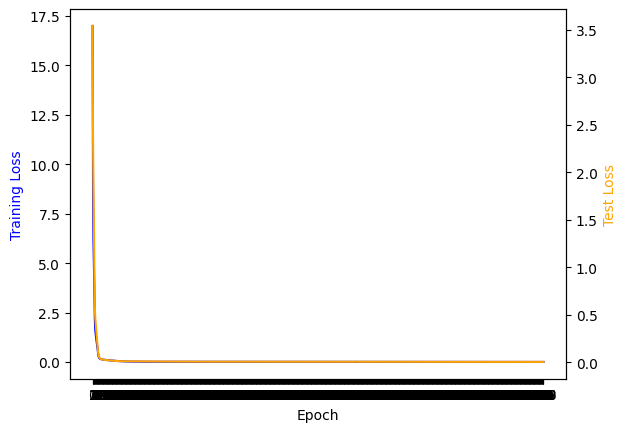

100%|██████████| 1000/1000 [01:25<00:00, 11.63it/s]

 Best Test Loss: 0.0032100528478622437


In [32]:
# Optimize model

network_dict = {
    "network": VariableANN,
    "kwargs": {"input_size": 3},
    "optimize_kwargs": {
        "dropout": {"name": "dropout", "low": 0.0, "high": 0.5, "step": 0.05},
        "neurons": {"name": "neurons", "low": 16, "high": 256, "step": 16, "multi": np.random.randint(3, 6)},
    },
}


optimizer_dict = {
    "optimizer": optim.Adam,
    "kwargs": {},
    "optimize_kwargs": {
        "lr": {"name": "lr", "low": 1e-5, "high": 1e-1, "log": True},
        "weight_decay": {"name": "weight_decay", "low": 1e-5, "high": 1e-3, "log": True},
    },
}

best_network, best_optimizer = model.optimize_network(
    trial_count, "minimize", network_dict, optimizer_dict, loss_fn, epochs
)

trained_net = model.train_model("Model1", best_network, best_optimizer, loss_fn, 1000, plot_output=True)

In [33]:
# TESTING
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")
valid_rmse, _, valid_predictions = model.validate_model(trained_net, "valid")

print(model.train_labels[1].mean())

RMSE: 0.009961
MAE: 0.005449
RMSE: 0.008446
MAE: 0.005253
0.49119488874278283


## Optimizing

In [34]:
def run_fn(wg_spacing_coup, coup_length):
    freq = freq0
    feature_array = np.array((wg_spacing_coup, coup_length, freq))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)

    # return prediction[0]
    return -(abs(prediction[0] - 0.25)**2 + abs(prediction[1] - 0.75)**2)

In [35]:
method = tdd.MethodBayOpt(
    initial_iter=500,
    n_iter=100,
    acq_func='ucb',
    kappa=10,
    xi=0.9,
    seed=1,
)

predict_parameters = parameters

output_dir = "/home/matt/Documents/Flexcompute/mmi/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=predict_parameters,
    task_name="dc_predict_1",
    folder_name="DCV1",
    path_dir=output_dir,
)

In [36]:
predict_results = design_space.run(run_fn, verbose=True)
predict_df = predict_results.to_dataframe()

17:43:16 BST Best Fit from Initial Solutions: -0.0                              
             

17:44:51 BST Best Result: -6.408347444519791e-05                                
             Best Parameters: coup_length: 6.443073730510251 wg_spacing_coup:   
             0.24772323088248976                                                
             

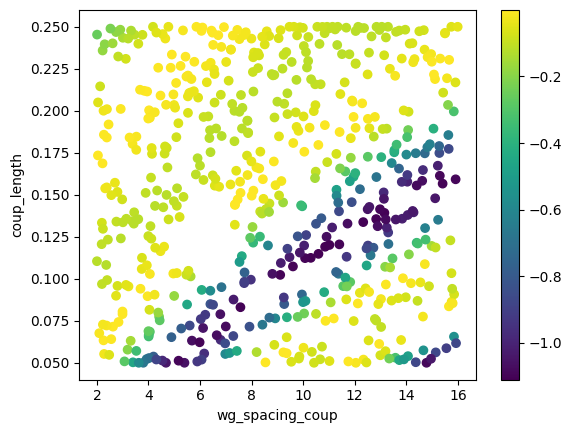

In [47]:
predict_scatter = plt.scatter(predict_df["wg_spacing_coup"], predict_df["coup_length"], c=predict_df["output"])
plt.xlabel("wg_spacing_coup")
plt.ylabel("coup_length")
plt.colorbar(predict_scatter)
plt.show()

In [37]:
import tidy3d.web as web
sim = make_sim(**predict_results.optimizer.max['params'])
sim_data = web.run(sim, task_name="best_predicted")

17:47:02 BST Created task 'best_predicted' with task_id                         
             'fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=733993;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=760450;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\taskId]8;;\]8;id=733993;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\=]8;;\]8;id=808545;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\fdve]8;;\]8;id=733993;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\-f67ca83f-e00]8;;\
             ]8;id=733993;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\9-42f3-b432-5bccb4a3bea2']8;;\.

Output()

17:47:05 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:47:18 BST status = preprocess

17:47:21 BST Maximum FlexCredit cost: 0.597. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

17:49:52 BST early shutoff detected at 48%, exiting.

             status = postprocess

Output()

17:49:56 BST status = success

             View simulation result at                                          
             ]8;id=221517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=456140;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\taskId]8;;\]8;id=221517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\=]8;;\]8;id=376986;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\fdve]8;;\]8;id=221517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\-f67ca83f-e00]8;;\
             ]8;id=221517;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f67ca83f-e009-42f3-b432-5bccb4a3bea2\9-42f3-b432-5bccb4a3bea2']8;;\.

Output()

17:49:57 BST loading simulation from simulation_data.hdf5

In [46]:
amps_dict = measure_transmission(sim_data)
print(f"Top: {round(float(abs(amps_dict['top'].sel({'f': freq0}))**2), 3)}, Bottom: {round(float(abs(amps_dict['bottom'].sel({'f': freq0}))**2), 3)}")

Top: 0.24, Bottom: 0.747


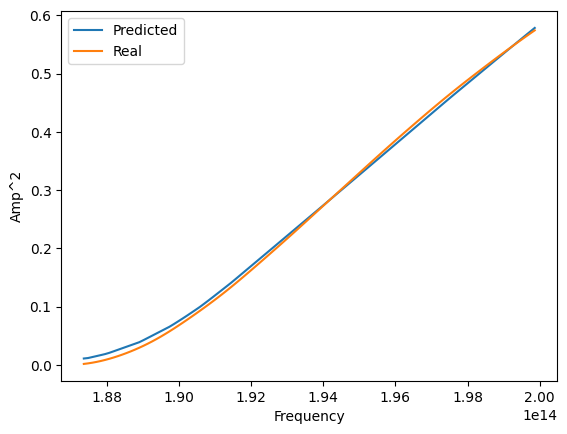

In [50]:
top_amp_predict = []
top_amp_real = []
bot_amp_predict = []
bot_amp_real = []
for freq_val in freqs:
    feature_array = np.array((0.24772323088248976, 6.443073730510251, freq_val))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 2)
    top_amp_predict.append(prediction[0])
    top_amp_real.append(float(abs(amps_dict['top'].sel({'f': freq_val}))**2))

    bot_amp_predict.append(prediction[1])
    bot_amp_real.append(float(abs(amps_dict['bottom'].sel({'f': freq_val}))**2))

fig, (ax1, ax2) = plt.subplot(1, 2, tight_layout=True, figsize=(10, 5))

plt.plot(freqs, top_amp_predict, label="Predicted")
plt.plot(freqs, top_amp_real, label="Real")
plt.xlabel("Frequency")
plt.ylabel("Amp^2")
plt.legend()
plt.show()